the design of the model is based on the famous paper "Design Space for Graph Neural Networks"


# Applying a GCN to the elliptic Bitcoin blockchain transaction dataset

## Prepare and inspect the data 

1.   edges, each row contains two TxIDs representing the connection between two transactions 
2.   classes, contains a class for each transaction. The are three classes, lecit, illecit and unknwown
3.   features, contains all the features for each transaction. This includes a set of fetures of the node itself and a set of features obtained from the connected nodes.



### imports 

In [2]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sklearn 


/home/karthik/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )
    

    return history


In [4]:

def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()


In [5]:

def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

### data retrival 

In [6]:
zip_file = keras.utils.get_file(
    fname="elliptic.zip",
    origin="https://www.kaggle.com/datasets/ellipticco/elliptic-data-set/data",
    extract=True,
)
print(zip_file)


/home/karthik/.keras/datasets/elliptic.zip


In [7]:
cd "3us/step/home/karthik/.keras/datasets/elliptic.zip"


[Errno 2] No such file or directory: '3us/step/home/karthik/.keras/datasets/elliptic.zip'
/home/karthik/AML/GCN_detect_bitcoin_money_laundering


In [8]:
#cd /root/.keras/datasets/elliptic_bitcoin_dataset

In [9]:
edges = pd.read_csv("elliptic_txs_edgelist.csv")
features = pd.read_csv("elliptic_txs_features.csv",header=None)
classes = pd.read_csv("elliptic_txs_classes.csv")

In [10]:
print(edges.shape)
print(features.shape)

(234355, 2)
(203769, 167)


### data preparation 

Name all the features, differentiate features (only node, multiple nodes) and go for 0 class instead of unknown 

In [11]:
tx_features = ["tx_feat_"+str(i) for i in range(2,95)]
agg_features = ["agg_feat_"+str(i) for i in range(1,73)]
features.columns = ["txId","time_step"] + tx_features + agg_features

#merge features and classes
features = pd.merge(features,classes,left_on="txId",right_on="txId",how='left')
features['class'] = features['class'].apply(lambda x: '0' if x == "unknown" else x)

In the first part of the analysis we are interested only in the known part of the network. We use the known part so to have a known reference for training. 


In [12]:
# get the features of the known transactions
features= features[features['class'] != '0' ]

In [13]:
def check(name):
  if(name in unique):
    return name 
  else : 
    return -1 

In [14]:
# remove from the edges DF all the entries that mentions the unknown transactions
unique = features['txId'].unique()
edges["txId1"] = edges["txId1"].apply(lambda name: check(name))
edges["txId2"] = edges["txId2"].apply(lambda name: check(name))

In [15]:
edges = edges[edges["txId1"] != -1 ]
edges = edges[edges["txId2"] != -1 ]

In [16]:
print(edges.shape)
print(features.shape)

(36624, 2)
(46564, 168)


### swap the index 

Change the txID in both features and edges to a simple index. This makes the computation of the adjency matrix easier

In [17]:
class_values = sorted(features["class"].unique())
#we create a new index by sorting the tx_ids and assign to it a number 
features_idx = {name: idx for idx, name in enumerate(sorted(features["txId"].unique()))}

# we then apply this new ids to all te data frames 
# this helps a lot in computing the adjency matrix, having the ids as the index.
features["txId"] = features["txId"].apply(lambda name: features_idx[name])
edges["txId1"] = edges["txId1"].apply(lambda name: features_idx[name])
edges["txId2"] = edges["txId2"].apply(lambda name: features_idx[name])

### prepare the data for the GCN architecture 

The GCN works with an asset containing the whole graph. Of course, we give the network only the tx_features, as we are trying to learn all the agg_features ourselves. 

In [18]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges2 = edges[["txId1", "txId2"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges2.shape[1])
# Create a node features array of shape [num_nodes, num_features].
# IN the next line we select the features to include in the graph 
# Notice than only tx_features are present!

node_features = tf.cast(
    features.sort_values("txId")[tx_features].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges2, edge_weights)

print("Edges shape:", edges2.shape)
print("Nodes shape:", node_features.shape)
print("edge weights shape:", edge_weights.shape)

Edges shape: (2, 36624)
Nodes shape: (46564, 93)
edge weights shape: (36624,)


2023-12-26 23:04:37.730665: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-26 23:04:37.730686: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (karthik-HP-Pavilion-Laptop-15-eg2xxx): /proc/driver/nvidia/version does not exist
2023-12-26 23:04:37.731341: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Build the GCN model 

In [19]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


In [20]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


### set the hyperparameters 

In [21]:
# Define the parameters for the network 

num_classes = len(class_values)
print("num classes = " , num_classes)

hidden_units = [32, 32]
learning_rate = 0.007
dropout_rate = 0.6
#0.5
num_epochs = 30
batch_size = 256
#256

num classes =  2


In [22]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1,10,100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[-2.5593235  -5.8212867 ]
 [-0.5203702  -0.5505327 ]
 [ 0.03265724 -0.1205126 ]], shape=(3, 2), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (46564, 32)               4564      
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 postprocess (Sequential)    (46564, 32)               2368      
                                                                 
 logits (Dense)              multiple           

## Train the model

In [23]:
from sklearn.model_selection import train_test_split

X = features[tx_features + ['txId'] ]
y = features['class']
y = y.apply(lambda x: 0 if x == '2' else 1 )
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=117,shuffle=True)

In [24]:
# for training I only need txID, everything else is already in the network 
x_train = X_train.txId.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/30
109/109 [==============================] - 24s 211ms/step - loss: 0.3248 - acc: 0.8942 - val_loss: 0.2887 - val_acc: 0.9110
Epoch 2/30
109/109 [==============================] - 21s 194ms/step - loss: 0.2745 - acc: 0.8988 - val_loss: 0.1786 - val_acc: 0.9110
Epoch 3/30
109/109 [==============================] - 21s 194ms/step - loss: 0.2436 - acc: 0.9090 - val_loss: 0.2188 - val_acc: 0.9110
Epoch 4/30
109/109 [==============================] - 21s 195ms/step - loss: 0.2178 - acc: 0.9257 - val_loss: 0.1784 - val_acc: 0.9110
Epoch 5/30
109/109 [==============================] - 21s 194ms/step - loss: 0.2034 - acc: 0.9337 - val_loss: 0.1470 - val_acc: 0.9673
Epoch 6/30
109/109 [==============================] - 21s 193ms/step - loss: 0.1971 - acc: 0.9392 - val_loss: 0.1310 - val_acc: 0.9673
Epoch 7/30
109/109 [==============================] - 21s 197ms/step - loss: 0.1913 - acc: 0.9421 - val_loss: 0.1291 - val_acc: 0.9654
Epoch 8/30
109/109 [==============================] - 2

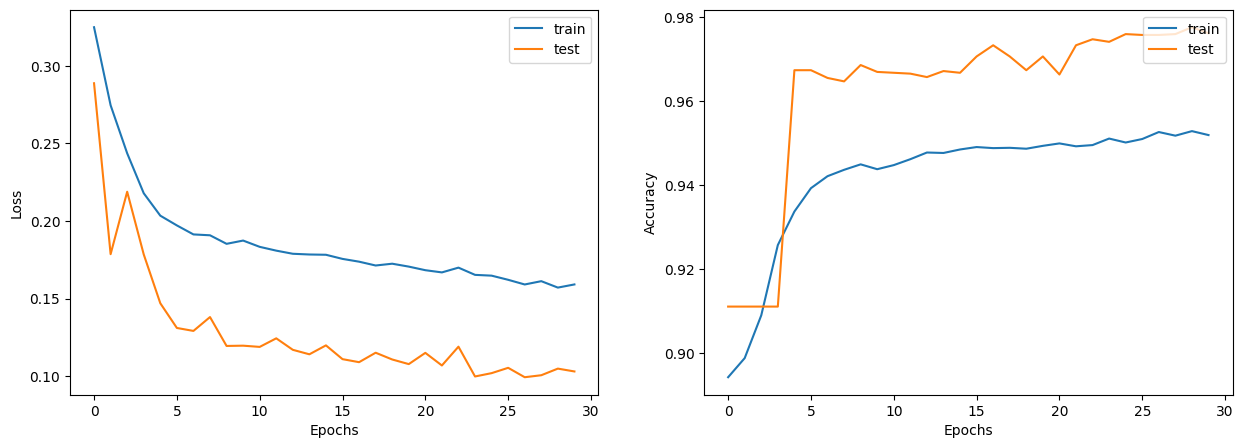

In [25]:
display_learning_curves(history)

## Test the results

In [26]:
x_test = X_test.txId.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 97.24%


In [27]:
preds = gnn_model.predict(x_test)

In [28]:
norm_preds = sklearn.preprocessing.normalize(preds)

y_predicted = []
for pred in norm_preds:
  if pred[0] > pred[1]:
    y_predicted.append(0)
  else :
    y_predicted.append(1)

In [29]:
prec,rec,f1,num = sklearn.metrics.precision_recall_fscore_support(y_test,y_predicted, average=None)
print("Convoluted neural network")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = sklearn.metrics.f1_score(y_test,y_predicted,average='micro')
print("Micro-Average F1 Score:",micro_f1)

Convoluted neural network
Precision:0.919 
Recall:0.776 
F1 Score:0.841
Micro-Average F1 Score: 0.9724409448818898


#### Load and save model 

In [30]:
gnn_model.save('/home/karthik/AML/pallavi/FedLearning')

2023-12-26 23:16:14.717688: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/karthik/AML/pallavi/FedLearning/assets


In [31]:
model = keras.models.load_model('/home/karthik/AML/pallavi/FedLearning')

## Compare with the other models 

In [32]:
# read the results file produced by the other notebook. (you have to upload them yourself)
compare = pd.read_csv("/home/karthik/AML/GCN_detect_bitcoin_money_laundering/1_result_elliptic.csv",usecols=[1,2,3,4,5])

In [33]:
compare = pd.DataFrame(columns=['model', 'Precision', 'Recall', 'F1 Score', 'M.A F1 Score'])
new_data = {
    'model': ["GCN"],
    'Precision': [np.round(prec[1], 3)],
    'Recall': [np.round(rec[1], 3)],
    'F1 Score': [np.round(f1[0], 3)],
    'M.A F1 Score': [np.round(micro_f1, 3)]
}
print(new_data)
new_row = pd.DataFrame(new_data)
compare = pd.concat([compare, new_row], ignore_index=True)

{'model': ['GCN'], 'Precision': [0.919], 'Recall': [0.776], 'F1 Score': [0.985], 'M.A F1 Score': [0.972]}


/tmp/ipykernel_8449/3607287739.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  compare = pd.concat([compare, new_row], ignore_index=True)


In [34]:
compare.head(10)

,model,Precision,Recall,F1 Score,M.A F1 Score
0,GCN,0.919,0.776,0.985,0.972


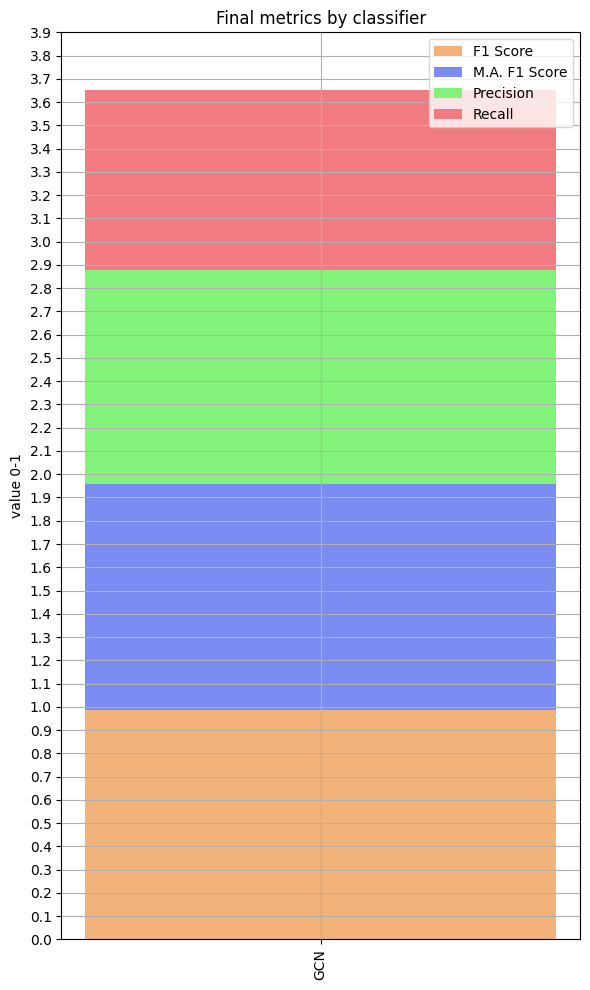

In [35]:

labels = compare['model'].to_numpy()
precision = compare['Precision'].to_numpy()
recall = compare['Recall'].to_numpy()
f1 = compare['F1 Score'].to_numpy()
maf1 = compare['M.A F1 Score'].to_numpy()

x = np.arange(len(labels))  # the label locations
width = 0.55  # the width of the bars
fig, ax = plt.subplots(figsize=(6, 10))
f1_rects = ax.bar(x, f1, width, label='F1 Score',color='#f2b37b')
MAf1_rects = ax.bar(x , maf1, width, label='M.A. F1 Score',color='#7b8bf2',bottom=f1)
prec_rects = ax.bar(x, precision, width, label='Precision',color='#83f27b',bottom=maf1 + f1)
rec_rects = ax.bar(x, recall, width, label='Recall',color='#f27b83',bottom=maf1 + f1 + precision)

ax.set_ylabel('value 0-1')
ax.set_title('Final metrics by classifier')
ax.set_xticks(np.arange(0,len(labels),1))
ax.set_yticks(np.arange(0,4,0.1))
ax.set_xticklabels(labels=labels)
ax.legend()

plt.xticks(rotation=90)
plt.grid(True)
fig.tight_layout()
plt.show()

In [36]:
# save the results for later use 
compare.to_csv("/home/karthik/GCN_detect_bitcoin_money_laundering/2_result_elliptic.csv")